<a href="https://colab.research.google.com/github/RuchchaSD/Useful_files/blob/main/Evaluate_traj_TUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

%matplotlib inline

In [26]:
def read_file_list(filename: str) -> Dict[float, List[str]]:
    """
    Reads a trajectory or data file where each line has:
        timestamp d1 d2 d3 ...
    Returns a dictionary: { timestamp: [d1, d2, d3, ...], ... }
    """
    data_dict = {}
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith("#"):
                continue  # Skip empty lines and comments
            parts = line.replace(",", " ").replace("\t", " ").split()
            if len(parts) < 2:
                continue  # Skip lines that don't have enough data
            try:
                timestamp = float(parts[0])
                data = parts[1:]
                data_dict[timestamp] = data
            except ValueError:
                continue  # Skip lines with invalid float conversion
    return data_dict

def associate(
    first_list: Dict[float, List[str]],
    second_list: Dict[float, List[str]],
    offset: float,
    max_difference: float
) -> List[Tuple[float, float]]:
    """
    Associates two dictionaries of (timestamp -> data).
    Finds pairs (a, b) such that |a - (b + offset)| < max_difference.
    Each timestamp is matched at most once.
    Returns a sorted list of matched (stamp1, stamp2).
    """
    matches = []
    used_first = set()
    used_second = set()

    # Sort the timestamps for efficient matching
    first_keys = sorted(first_list.keys())
    second_keys = sorted(second_list.keys())

    i, j = 0, 0
    while i < len(first_keys) and j < len(second_keys):
        a = first_keys[i]
        b = second_keys[j] + offset
        diff = abs(a - b)
        if diff < max_difference:
            if a not in used_first and second_keys[j] not in used_second:
                matches.append((a, second_keys[j]))
                used_first.add(a)
                used_second.add(second_keys[j])
                i += 1
                j += 1
            elif b < a:
                j += 1
            else:
                i += 1
        elif b < a:
            j += 1
        else:
            i += 1

    return matches


In [27]:
def align(model: np.ndarray, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Aligns two trajectories using the method of Horn (closed-form).

    Parameters:
        model (np.ndarray): The estimated trajectory (3 x n).
        data (np.ndarray): The ground truth trajectory (3 x n).

    Returns:
        rot (np.ndarray): Rotation matrix (3 x 3).
        trans (np.ndarray): Translation vector (3 x 1).
        trans_error (np.ndarray): Translational error per point (n,).
        s (float): Scale factor.
    """
    np.set_printoptions(precision=3, suppress=True)

    # Zero-center the trajectories
    model_mean = model.mean(axis=1, keepdims=True)
    data_mean = data.mean(axis=1, keepdims=True)
    model_zero = model - model_mean
    data_zero = data - data_mean

    # Compute W matrix
    W = model_zero @ data_zero.T

    # SVD of W
    U, _, Vt = np.linalg.svd(W)
    S = np.identity(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[2, 2] = -1
    rot = U @ S @ Vt

    # Compute scale
    rot_model = rot @ model_zero
    dots = np.sum(data_zero * rot_model)
    norms = np.sum(model_zero ** 2)
    s = dots / norms
    print(f"Scale factor: {s}")

    # Compute translation
    trans = data_mean - s * rot @ model_mean

    # Align the model
    model_aligned = s * rot @ model + trans
    alignment_error = model_aligned - data
    trans_error = np.linalg.norm(alignment_error, axis=0)

    return rot, trans, trans_error, s

def plot_traj(ax, stamps: List[float], traj: np.ndarray, style: str, color: str, label: str):
    """
    Plots a trajectory on the given Axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        stamps (List[float]): Time stamps.
        traj (np.ndarray): Trajectory data (3 x n).
        style (str): Line style.
        color (str): Line color.
        label (str): Label for the plot.
    """
    sorted_indices = np.argsort(stamps)
    sorted_stamps = np.array(stamps)[sorted_indices]
    sorted_traj = traj[:, sorted_indices]

    # Calculate median interval
    intervals = np.diff(sorted_stamps)
    interval = np.median(intervals)

    x, y = [], []
    last_stamp = sorted_stamps[0]
    for stamp, point in zip(sorted_stamps, sorted_traj.T):
        if stamp - last_stamp < 2 * interval:
            x.append(point[0])
            y.append(point[1])
        else:
            if x and y:
                ax.plot(x, y, style, color=color, label=label if not ax.get_legend_handles_labels()[1] else "")
                x, y = [], []
        last_stamp = stamp
    if x and y:
        ax.plot(x, y, style, color=color, label=label if not ax.get_legend_handles_labels()[1] else "")


In [32]:
def compute_absolute_trajectory_error(
    first_file: str, # ground truth
    second_file: str, #estimate
    offset: float = 0.0,
    scale: float = 1.0,
    max_difference: float = 0.02,
    save: str = None,
    save_associations: str = None,
    plot_path: str = None,
    verbose: bool = False
) -> Dict[str, Any]:
    """
    Computes the absolute trajectory error between ground truth and estimated trajectories.

    Parameters:
        first_file (str): Path to ground truth trajectory file.
        second_file (str): Path to estimated trajectory file.
        offset (float): Time offset for second trajectory.
        scale (float): Scaling factor for second trajectory.
        max_difference (float): Maximum allowed time difference for matching.
        save (str): Path to save aligned second trajectory.
        save_associations (str): Path to save associated trajectories.
        plot_path (str): Path to save the plot image.
        verbose (bool): If True, prints detailed error metrics.

    Returns:
        Dict[str, Any]: Contains rotation matrix, translation vector, scale, and errors.
    """
    # Read the trajectory files
    first_list = read_file_list(first_file)
    print(f"Loaded {len(first_list)}, {len(first_list)}")
    second_list = read_file_list(second_file)
    print(f"Loaded {len(second_list)}, {len(second_list)}")

    # Associate the timestamps
    matches = associate(first_list, second_list, offset, max_difference)
    if len(matches) < 2:
        print("Not enough matching timestamp pairs between ground truth and estimated trajectory!")
        return {}

    # Extract matched trajectory points
    first_xyz = np.array([
        [float(coord) for coord in first_list[a][0:3]]
        for a, _ in matches
    ]).T  # Shape: 3 x n

    second_xyz = np.array([
        [float(coord) * scale for coord in second_list[b][0:3]]
        for _, b in matches
    ]).T  # Shape: 3 x n

    # Align the estimated trajectory to the ground truth
    rot, trans, trans_error, computed_scale = align(second_xyz, first_xyz)
    second_xyz_aligned = computed_scale * rot @ second_xyz + trans

    # Compute RMSE
    rmse = np.sqrt(np.mean(trans_error ** 2))
    if verbose:
        print(f"Number of matched pairs: {len(trans_error)}")
        print(f"RMSE: {rmse:.6f} m")
        print(f"Mean error: {np.mean(trans_error):.6f} m")
        print(f"Median error: {np.median(trans_error):.6f} m")
        print(f"Std Dev: {np.std(trans_error):.6f} m")
        print(f"Min error: {np.min(trans_error):.6f} m")
        print(f"Max error: {np.max(trans_error):.6f} m")
    else:
        print(f"RMSE: {rmse:.6f} m")

    # Save aligned trajectory
    if save:
        with open(save, 'w') as f:
            for stamp, point in zip(sorted(second_list.keys()), second_xyz_aligned.T):
                f.write(f"{stamp} {' '.join(map(str, point))}\n")
        print(f"Aligned trajectory saved to {save}")

    # Save associations
    if save_associations:
        with open(save_associations, 'w') as f:
            for (a, b), (x1, y1, z1), (x2, y2, z2) in zip(
                matches, first_xyz.T, second_xyz_aligned.T
            ):
                f.write(f"{a} {x1} {y1} {z1} {b} {x2} {y2} {z2}\n")
        print(f"Associations saved to {save_associations}")

    # Plot trajectories
    if plot_path:
        # Prepare full trajectories for plotting
        first_stamps = sorted(first_list.keys())
        first_xyz_full = np.array([
            [float(coord) for coord in first_list[s][0:3]]
            for s in first_stamps
        ]).T  # Shape: 3 x m

        second_stamps = sorted(second_list.keys())
        second_xyz_full = np.array([
            [float(coord) * scale for coord in second_list[s][0:3]]
            for s in second_stamps
        ]).T  # Shape: 3 x p
        second_xyz_full_aligned = computed_scale * rot @ second_xyz_full + trans

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 8))
        plot_traj(ax, first_stamps, first_xyz_full, '-', 'black', 'Ground Truth')
        plot_traj(ax, second_stamps, second_xyz_full_aligned, '-', 'blue', 'Estimated')

        # Plot differences
        for (a, b), point_gt, point_est in zip(matches, first_xyz.T, second_xyz_aligned.T):
            ax.plot([point_gt[0], point_est[0]], [point_gt[1], point_est[1]], '-', color='red')

        ax.legend()
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_title('Trajectory Alignment')
        plt.grid(True)
        plt.savefig(plot_path, dpi=300)
        plt.show()
        print(f"Plot saved to {plot_path}")

    return {
        'rotation': rot,
        'translation': trans,
        'scale': computed_scale,
        'trans_error': trans_error,
        'rmse': rmse
    }


Loaded 3679, 3679
Loaded 3638, 3638
Scale factor: -0.06705479209882044
Number of matched pairs: 2547
RMSE: 0.827566 m
Mean error: 0.768055 m
Median error: 0.853595 m
Std Dev: 0.308151 m
Min error: 0.186792 m
Max error: 1.417753 m
Aligned trajectory saved to aligned_estimated.txt
Associations saved to associations.txt


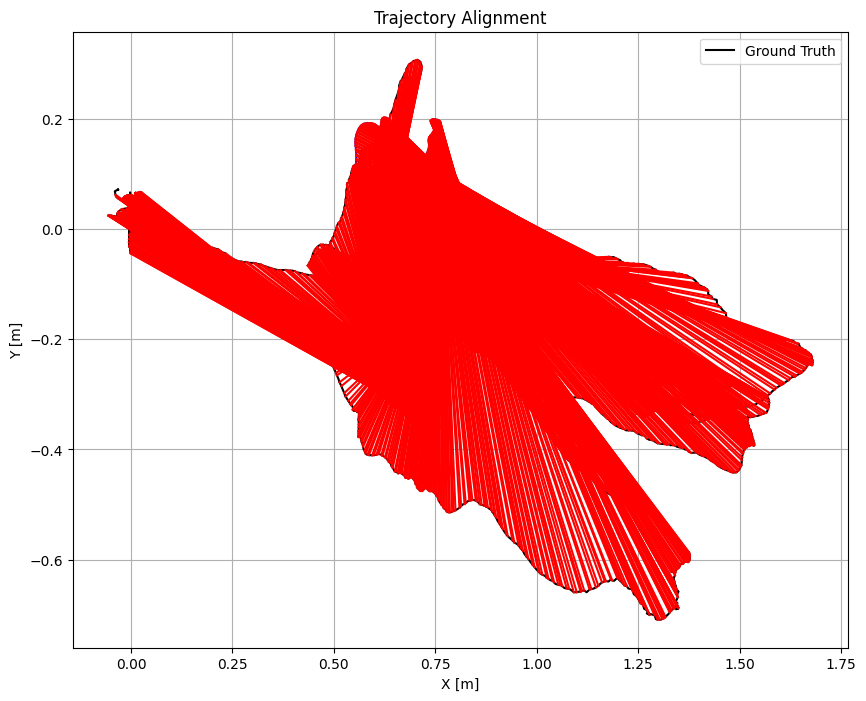

Plot saved to trajectory_plot.png
Computed RMSE: 0.827566 meters


In [38]:
# Example usage of the compute_absolute_trajectory_error function

# Define file paths (update these paths as necessary)
ground_truth_file = '/content/MH04.txt'    # Replace with your ground truth file path
estimated_file = '/content/MH04_GT.txt'        # Replace with your estimated trajectory file path

# Define parameters
time_offset = 0.0                        # Adjust if there's a known time offset
scaling_factor = 1.0                     # Adjust if scaling is needed
max_time_diff = 0.02                     # Maximum time difference for association

# Output paths
aligned_estimated_file = 'aligned_estimated.txt'
associations_file = 'associations.txt'
plot_image_path = 'trajectory_plot.png'

# Compute Absolute Trajectory Error
results = compute_absolute_trajectory_error(
    first_file=ground_truth_file,
    second_file=estimated_file,
    offset=time_offset,
    scale=scaling_factor,
    max_difference=max_time_diff,
    save=aligned_estimated_file,
    save_associations=associations_file,
    plot_path=plot_image_path,
    verbose=True
)

# Display RMSE
if results:
    print(f"Computed RMSE: {results['rmse']:.6f} meters")


In [ ]:
# For plotting (only needed if you plan to use the --plot option)
# Note: if running in a non-interactive environment, you may need:
  # %matplotlib inline
# or
  # %matplotlib notebook
# inside your notebook for plots to display.